# Axially symmetric modeling
*Prof. dr.ir. T.N.Olsthoorn*

*Heemstede, okt. 2016*

## Theory

In [1]:
myModules = '/Users/Theo/GRWMODELS/Python_projects/mfpy/modules/'

import sys
if not myModules in sys.path:
    sys.path.append(myModules)

import mfgrid

Often it is useful to simulate groundwater flow in an axial symmetric using only the coordinates x and z, where x stands for the radius r and y is not used. The thickness in y direction is no longer constant but varies with x as $y = 2 \pi x^2$. Note that here $x>0$. Columns in the grid are now, in fact, cylinders with thickness equal to that of the corresponding column.

To alow this, we have to adapt the computation of the cell resistances. Because in axial flow we have

$\Delta \phi = \frac {Q} {2 \pi k_x \Delta z} \ln \frac {r_1} {r_2} $

The resistance $R_x = \frac {\Delta \phi} {Q} = \frac 1 {2 \pi k_x \Delta z} \ln \frac {r_2} {r_1} $, with $r_2 > r_1$

We can thus write out the resistance against horitonzal axial flow between the innermost cell face at $x=r_1$ and the cell center at $x=r_m$ as well as the resistance between the cell center and the outer most cell face at $x=r_2$.

    Rx1 = 1 / (2 * pi * kx * dz) * log(xm / x[:-1])
    Rx2 = 1 / (2 * pi * kx * dz) * log(x[1:] / xm)

In vertical direction we have the resistance due to vertical flow through the rings

$R_z = \frac {\Delta z} { k_z \pi (r_2^2 - r_1^2) }$

These resistances thus become:

    Rz  = dz / (kz * pi * (x[1:]**2 - x[:-1]**2))

And the cell conductances now become

    Cx = 1 / (Rx1[1:] + Rx2[:-1])
    Cy = np.zeros(sz)
    Cz = 0.5 / (Rz[:,:,1:] + Rz[:,:,:-1])

Notice that the conductance in the y direction is left in and set to zeros. This implies that there will be no flow between adjacent model rows. When we now use a model with more than one row, we can look at it as a set of simultaneously computed independent axisymmetric models, because these models all share the same distance from zero by their x-coordinate and have no mutual interaction in the y-direction. Different axisymmetric models can thus be simulated simultaneously, which may be useful for comparisons, sensitivity compuatations and for calibration.

These are the only changes we have to make to convert our 3D groundwater model to an axisymmetric model.

We can build this into our existing model and use a switch to tell the model to run the rectangular or the  axisymmetric case.

In Python this is easily done using a named input parameter `axial=false`.

The call would then look as follows

    Phi = fdm3(x, y, z, kx, ky, kz, FQ, HI, IBOUND, axial=true)

The y coordinate vector is irrelevant here. It can be left empty or set to any value, e.g. `none`. Whatever it is, it will be ignored in the axisymmetrical case. Notice that the size of the model is obtained from the IBOUND array.

## Implementation; the adepted module to include axial symmetry

In [1]:
%%writefile fdm_d.py

import numpy as np
import pdb
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve # to use its short name
from collections import namedtuple

class InputError(Exception):
    pass

def quivdata(Out, gr, iz=0):
    """Returns coordinates and velocity components to show velocity with quiver
    
    Compute arrays to display velocity vectors using matplotlib's quiver.
    The quiver is always drawn in the xy-plane for a specific layer. Default iz=0
    
    Parameters
    ----------
    `Out` : namedtuple holding arrays `Qx`, `Qy`, `Qz` as defined in `fdm3`
        `Qx` : ndarray, shape: (Ny, Nx-1, Nz), [L3/T]
            Interfacial flows in finite difference model in x-direction from `fdm3'
        `Qy` : ndarray, shape: (Ny-1, Nx, Nz), [L3/T]
            Interfacial flows in finite difference model in y-direction from `fdm3`
        `Qz` : ndarray, shape: (Ny, Nx, Nz-1), [L3/T]
            Interfacial flows in finite difference model in z-direction from `fdm3`            
    `gr` : `grid_object` generated by Grid
    `iz` : int [-]
            iz is the number of the layer for which the data are requested,
            and all output arrays will be 2D for that layer.
            if iz==None, then all outputs will be full 3D arrays and cover all layers
            simultaneously

    Returns
    -------
    `Xm` : ndarray, shape: (Ny, Nx, Nz), [L]
        x-coordinates of cell centers
    `Ym` : ndarray, shape: (Ny, Nx, Nz), [L]
        y-coodinates of cell centers
    `ZM` : ndarray, shape: (Ny, Nx, Nz), [L]
        `z`-coordinates at cell centers
    `U` : ndarray, shape: (Ny, Nx, Nz), [L3/d]
        Flow in `x`-direction at cell centers
    `V` : ndarray, shape: (Ny, Nx, Nz), [L3/T]
        Flow in `y`-direction at cell centers
    `W` : ndarray, shape: (Ny, Nx, Nz), [L3/T]
        Flow in `z`-direction at cell centers.
    
    """
    
    X, Y = np.meshgrid(gr.xm, gr.ym) # coordinates of cell centers
    
    shp = (gr.Ny, gr.Nx) # 2D tuple to select a single layer
    
    # Flows at cell centers
    U = np.concatenate((Out.Qx[:,0,iz].reshape((gr.Ny,1,1)), \
                        0.5 * (Out.Qx[:,:-1,iz].reshape((gr.Ny,gr.Nx-2,1)) +\
                               Out.Qx[:, 1:,iz].reshape((gr.Ny,gr.Nx-2,1))), \
                        Out.Qx[:,-1,iz].reshape((gr.Ny,1,1))), axis=1).reshape(shp)
    V = np.concatenate((Out.Qy[0, :,iz].reshape((1,gr.Nx,1)), \
                        0.5 * (Out.Qy[:-1,:,iz].reshape((gr.Ny-2,gr.Nx,1)) +\
                               Out.Qy[ 1:,:,iz].reshape((gr.Ny-2,gr.Nx,1))), \
                        Out.Qy[-1,:,iz].reshape((1,gr.Nx,1))), axis=0).reshape(shp)
    return X, Y, U, V


def unique(x, tol=0.0001):
    """return sorted unique values of x, keeping ascending or descending direction"""
    if x[0]>x[-1]:  # vector is reversed
        x = np.sort(x)[::-1]  # sort and reverse
        return x[np.hstack((np.diff(x) < -tol, True))]
    else:
        x = np.sort(x)
        return x[np.hstack((np.diff(x) > +tol, True))]

    
def fdm3(gr, kx, ky, kz, FQ, HI, IBOUND):
    '''Steady state 3D Finite Difference Model returning computed heads and flows.
        
    Heads and flows are returned as 3D arrays as specified under output parmeters.
    
    Parameters
    ----------
    'gr' : `grid_object`, generated by gr = Grid(x, y, z, ..)
        if `gr.axial`==True, then the model is run in axially symmetric model
    `kx`, `ky`, `kz` : ndarray, shape: (Ny, Nx, Nz), [L/T]
        hydraulic conductivities along the three axes, 3D arrays.
    `FQ` : ndarray, shape: (Ny, Nx, Nz), [L3/T]
        prescrived cell flows (injection positive, zero of no inflow/outflow)
    `IH` : ndarray, shape: (Ny, Nx, Nz), [L]
        initial heads. `IH` has the prescribed heads for the cells with prescribed head.
    `IBOUND` : ndarray, shape: (Ny, Nx, Nz) of int
        boundary array like in MODFLOW with values denoting
        * IBOUND>0  the head in the corresponding cells will be computed
        * IBOUND=0  cells are inactive, will be given value NaN
        * IBOUND<0  coresponding cells have prescribed head
    
    outputs
    -------    
    `Out` : namedtuple containing heads and flows:
        `Out.Phi` : ndarray, shape: (Ny, Nx, Nz), [L3/T] 
            computed heads. Inactive cells will have NaNs
        `Out.Q`   : ndarray, shape: (Ny, Nx, Nz), [L3/T]
            net inflow in all cells, inactive cells have 0
        `Out.Qx   : ndarray, shape: (Ny, Nx-1, Nz), [L3/T] 
            intercell flows in x-direction (parallel to the rows)
        `Out.Qy`  : ndarray, shape: (Ny-1, Nx, Nz), [L3/T] 
            intercell flows in y-direction (parallel to the columns)
        `Out.Qz`  : ndarray, shape: (Ny, Nx, Nz-1), [L3/T] 
            intercell flows in z-direction (vertially upward postitive)
        the 3D array with the final heads with `NaN` at inactive cells.
    
    TO 160905
    '''

    import pdb
    
    # define the named tuple to hold all the output of the model fdm3
    Out = namedtuple('Out',['Phi', 'Q', 'Qx', 'Qy', 'Qz'])
    Out.__doc__ = """fdm3 output, <namedtuple>, containing fields Phi, Qx, Qy and Qz\n \
                    Use Out.Phi, Out.Q, Out.Qx, Out.Qy and Out.Qz"""                            
                                
    if gr.axial:
        print('Running in axial mode, y-values are ignored.')

    if kx.shape != gr.shape:
        raise AssertionError("shape of kx {0} differs from that of model {1}".format(kx.shape,SHP))
    if ky.shape != gr.shape:
        raise AssertionError("shape of ky {0} differs from that of model {1}".format(ky.shape,SHP))
    if kz.shape != gr.shape:
        raise AssertionError("shape of kz {0} differs from that of model {1}".format(kz.shape,SHP))
    
    active = (IBOUND>0).reshape(gr.Nod,)  # boolean vector denoting the active cells
    inact  = (IBOUND==0).reshape(gr.Nod,) # boolean vector denoting inacive cells
    fxhd   = (IBOUND<0).reshape(gr.Nod,)  # boolean vector denoting fixed-head cells

    # reshaping shorthands
    dx = np.reshape(gr.dx, (1, gr.Nx, 1))
    dy = np.reshape(gr.dy, (gr.Ny, 1, 1))

    # half cell flow resistances
    if not gr.axial:
        Rx1 = 0.5 *    dx / (   dy * gr.DZ) / kx
        Rx2 = Rx1
        Ry1 = 0.5 *    dy / (gr.DZ *    dx) / ky
        Rz1 = 0.5 * gr.DZ / (   dx *    dy) / kz
    else:
        min_dx = 0.000001
        x = gr.x; x[0] = max(0.1 * x[1],x[0]) # preventd division by zero x[0]
        Rx1 = 1 / (2 * np.pi * kx * gr.DZ) * np.log(x[1:] /  gr.xm).reshape((1, gr.Nx, 1))
        Rx2 = 1 / (2 * np.pi * kx * gr.DZ) * np.log(gr.xm / x[:-1]).reshape((1, gr.Nx, 1))
        Ry1 = np.inf * np.ones(gr.shape)
        Rz1 = 0.5 * gr.DZ / (np.pi * (gr.x[1:]**2 - gr.x[:-1]**2).reshape((1, gr.Nx, 1)) * kz)
    
    # set flow resistance in inactive cells to infinite
    Rx1[inact.reshape(gr.shape)] = np.inf
    Rx2[inact.reshape(gr.shape)] = np.inf
    Ry1[inact.reshape(gr.shape)] = np.inf
    Ry2 = Ry1
    Rz1[inact.reshape(gr.shape)] = np.inf
    Rz2 = Rz1
    
    # conductances between adjacent cells
    Cx = 1 / (Rx1[ :,1:,:] + Rx2[:,:-1,:])        
    Cy = 1 / (Ry1[:-1,:,:] + Ry2[ 1:,:,:])
    Cz = 1 / (Rz1[:,:,:-1] + Rz2[:,:, 1:])
    
    #pdb.set_trace()
    
    IE = gr.NOD[:,1:,:]  # east neighbor cell numbers
    IW = gr.NOD[:,:-1,:] # west neighbor cell numbers
    IN = gr.NOD[:-1,:,:] # north neighbor cell numbers
    IS = gr.NOD[1:,:,:]  # south neighbor cell numbers
    IT = gr.NOD[:,:,:-1] # top neighbor cell numbers
    IB = gr.NOD[:,:,1:]  # bottom neighbor cell numbers
    
    R = lambda x : x.ravel()  # generate anonymous function R(x) as shorthand for x.ravel()

    # notice the call  csc_matrix( (data, (rowind, coind) ), (M,N))  tuple within tupple
    # also notice that Cij = negative but that Cii will be postive, namely -sum(Cij)
    A = sp.csc_matrix(( -np.concatenate(( R(Cx), R(Cx), R(Cy), R(Cy), R(Cz), R(Cz)) ),\
                        (np.concatenate(( R(IE), R(IW), R(IN), R(IS), R(IB), R(IT)) ),\
                         np.concatenate(( R(IW), R(IE), R(IS), R(IN), R(IT), R(IB)) ),\
                      )),(gr.Nod,gr.Nod))
    
    # to use the vector of diagonal values in a call of sp.diags() we need to have it aa a 
    # standard nondimensional numpy vector.
    # To get this:
    # - first turn the matrix obtained by A.sum(axis=1) into a np.array by np.array( .. )
    # - then take the whole column to loose the array orientation (to get a dimensionless numpy vector)
    adiag = np.array(-A.sum(axis=1))[:,0]
    
    Adiag = sp.diags(adiag)  # diagonal matrix with a[i,i]
   
    #pdb.set_trace()

    RHS = FQ.reshape((gr.Nod,1)) - A[:,fxhd].dot(HI.reshape((gr.Nod,1))[fxhd]) # Right-hand side vector
    
    Out.Phi = HI.flatten() # allocate space to store heads
    
    Out.Phi[active] = spsolve( (A+Adiag)[active][:,active] ,RHS[active] ) # solve heads at active locations
    
    # net cell inflow
    Out.Q  = (A+Adiag).dot(Out.Phi).reshape(gr.shape)
    
    # reshape Phi to shape of grid
    Out.Phi = Out.Phi.reshape(gr.shape)
    
    #Flows across cell faces
    Out.Qx =  -np.diff( Out.Phi, axis=1) * Cx
    Out.Qy =  +np.diff( Out.Phi, axis=0) * Cy
    Out.Qz =  +np.diff( Out.Phi, axis=2) * Cz
    
        # set inactive cells to NaN
    Out.Phi[inact.reshape(gr.shape)] = np.NaN # put NaN at inactive locations

    
    return Out # all outputs in a named tuple for easy access

Overwriting fdm_d.py


## Examples

Here we'll work out a few axially symmetric examples to verify this model using analytical solutions.


We will also compute the darwdown in a multi-layer aquifer system.

We'll keep truly axially symmetric 3D flow for the next chapter, after we introduced the stream function.

In [6]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import fdm_d # from current directory
import mfgrid  # path has been added to sys.path above

# when we have been editing files, make sure to reload
reload(fdm_d)
reload(mfgrid)

<module 'mfgrid' from '/Users/Theo/GRWMODELS/Python_projects/mfpy/modules/mfgrid.py'>

### Circular island

The first example is flow in a circular island with recharge, like we did in a previous chapter using a large-scale 2D or 3D model.

We use a single layer, which, in axially symmetric cases becomes a single row of cells, in which `x` should be read as `r`, the distance to the center of the island.

Running in axial mode, y-values are ignored.


<IPython.core.display.Javascript object>


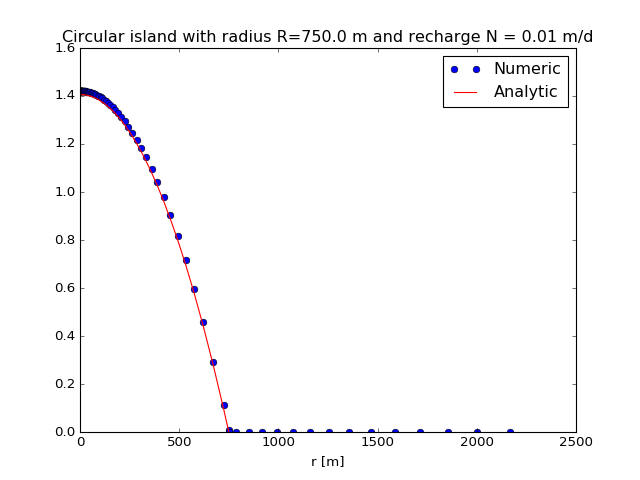

In [9]:
# easily switch between linear and axisymmetrical flow
axial = True

# m/d, recharge rate
rch = 0.01

# The aquifer
z0 = 0.  # m, ground surface elevaton
D = 100. # m, aquifer thickness

k0 = 10. # m/d, conductivity
kD = k0 * D # m2/d, transmissivity, only used in the analytical solution

# coordinates
R = 750.0 # m, radius of the island

# grid coordinates
# R-0.1 and R+0.1 added to x-coordinates to allow head boundary at almost exactly x==R
x = np.hstack([0., R-0.1, R+0.1, np.logspace(0 , np.log10(3*R), 100)])
y = np.array([-0.5, 0.5])  # is ignored in axially symmetric flow
z = z0 -  np.array([0, D])

# grid
gr = mfgrid.Grid(x, y, z, axial=axial) # generate a grid object and tell it's axially symmmetric

# required model arrays
k  = gr.const(k0) # m/d, uniform conductivity array of correct size
FQ = rch * gr.Area.reshape(gr.shape) # m3/d, cell inflows (gr.Area knows about axial)
IH = gr.const(0.) # m, initial heads
IBOUND = np.ones(gr.shape);   IBOUND[gr.XM>R] = -1 # boundary array, all r>R fixed heads

# run the model, return Out containing heads and flows
Out = fdm_d.fdm3(gr, k, k, k, FQ, IH, IBOUND)

# tells which cells are x<=R (in the island), used in analytical solutions
Island = np.logical_and(gr.xm>=-R, gr.xm<=R)

# plot, set up plot
plt.figure()

# plot numerical results
plt.plot(gr.xm,Out.Phi[0,:,0],'bo', label='Numeric')

# works for both axially symmetric and linear flow
# sets correct title and plots analytical solution
if axial:
    plt.xlabel('r [m]')
    plt.title('Circular island with radius R={0} m and recharge N = {1} m/d'.format(R,rch))
    plt.plot(gr.xm[Island], rch/(4 * kD) * (R**2 - gr.xm[Island] ** 2),'r-', label='Analytic')
else:
    plt.xlabel('x [m]')
    plt.title('Cross section with fixed head beyond x={0} m and recharge N = {1}'.format(R,rch))
    plt.plot(gr.xm[Island], rch/(2 * kD) * (R**2 - gr.xm[Island] ** 2),'r-', label='Analytic')
plt.legend()


As can be seen, the numerical and analyticl solutions agree. By changing the variable axial to False or True one can choose between a flat cross sectional model and an axisymmetrical model. The correct axis and analytical solutions will then be shown in the figure. The burden of changing variable for both cases is completely carried by the grid object and the way in which the conductances are computed in fdm3.

To show that the water balance matches we compute below the total flow into the model.

In [14]:
print('The total net Q into the model should be (well, almost) zero: Qtotal = {} m3/d'.format(np.sum(Out.Q.ravel())))

The total net Q into the model should be (well, almost) zero: Qtotal = 2.9467628337442875e-10 m3/d


In [29]:
if axial:
    dim='m3/d'
else:
    dim='m2/d'
    
print('The total net outflow should match the hand computed total recharge:')
print('By hand: rch * pi * R**2  =   {1:8.5g} {0}'.format(dim, rch * np.pi * R**2))
print('Total model computed inflow:  {1:8.5g} {0}'.format(dim, sum(Out.Q.ravel()[Out.Q.ravel()>0])))
print('Total model computed outflow: {1:8.5g} {0}'.format(dim, sum(Out.Q.ravel()[Out.Q.ravel()<0])))

The total net outflow should match the hand computed total recharge:
By hand: rch * pi * R**2  =      17671 m3/d
Total model computed inflow:     17676 m3/d
Total model computed outflow:   -17676 m3/d


### A well in a semi-confined aquifer

We can model semi-confined flow in a single aquifer with one layer for the confining unit on top and one or more for the aquifer below. Because the analytical solutions for flow to wells do not consider vertical resistance within the aquifer, it suffices to use a single layer for the aquifer to compare our model with the analytical solution.

The steady-state flow to a well in a semi-confined aquifer is governed by

$ s = \frac Q {2 \pi kD} \frac { K_0 \left( \frac r \lambda \right) }   {  \frac {r_0} \lambda K_1 \left( \frac {r_0} \lambda \right) } $

where $  \frac {r_0} \lambda K_1 \left( \frac {r_0} \lambda \right) \rightarrow 1 $ for $ r_0 << \lambda $.

With $ r_0 $ the radius of the well,  $ \lambda = \sqrt {\left( kDc \right)} $,  `c` [T] is the vertical hydraulic resistance of the confining unit and  `kD` [L2/T] the transmissivity of the underlying aquifer.

Running in axial mode, y-values are ignored.


<IPython.core.display.Javascript object>


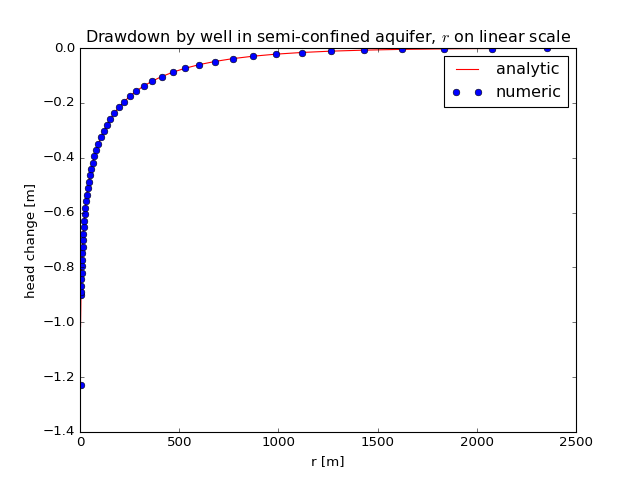

<IPython.core.display.Javascript object>


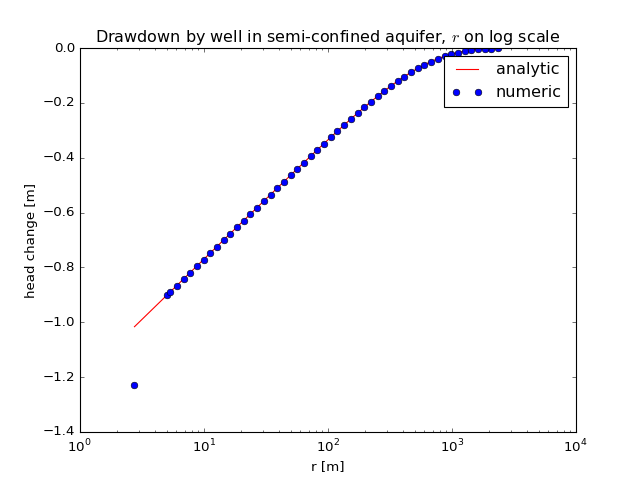

In [48]:
#aquifer
c = 250. # d, vertical hydraulic resistance of the confining unit
k1 =  20. # m/d, horizontal hydraulic conductivity of the aquifer
d =  10. # m, thickness of the confining unit
D =  50. # m, thickness of teh aquifer
k0 = 0.5 * d/c # m/d, vertical hydraulic conductivity of confining unit
               # 0.5 is used because water in the model enters at center of layer, not at top
kD = k1 * D # m2/d, transmissivity of aquifer
lam = np.sqrt(kD * c) # characteristic or spreading length of the semi-confind aquifer system

Q = 1200 # m3/d, extraction by well (we use -Q for extraction in model)

r0 = 5.0 # m, radius of the well
z0 = 0 # m, ground elevation, top of confining unit
z = z0 - np.array([0, d, d+D])
y = np.array([-0.5, 0.5])  # m, a one m thick model (ignored when axially symmetric)
x = np.hstack((0, 1.01*r0, np.logspace(np.log10(r0), np.log10(5*lam), 51)))
#x = np.hstack((0.99*r0, np.logspace(np.log10(r0), np.log10(5*lam), 51))) # inject exactly at r=r0

gr = mfgrid.Grid(x, y, z, axial=True)

k = gr.const(k1); k[:,:,0] = k0
FQ = gr.const(0.);  FQ[:,0,-1] = -Q
FH = gr.const(0.)
IBOUND = gr.const(1); IBOUND[:,:,0] = -1

Out = fdm_d.fdm3(gr, k, k, k, FQ, FH, IBOUND)

# analytical stuff
import scipy
K0 = scipy.special.k0 # bessel function
K1 = scipy.special.k1 # bessel function
# analytical solution
fi = -Q/(2 * np.pi * kD ) * K0(gr.xm / lam) / ((r0/lam) * K1(r0/lam))

plt.figure()
plt.xlabel('r [m]')
plt.ylabel('head change [m]')
plt.title('Drawdown by well in semi-confined aquifer, $ r $ on linear scale')
plt.plot(gr.xm, fi, 'r', label='analytic')
plt.plot(gr.xm, Out.Phi[0,:,-1], 'bo', label='numeric')
plt.legend()

plt.figure()
plt.xlabel('r [m]')
plt.ylabel('head change [m]')
plt.title('Drawdown by well in semi-confined aquifer, $ r $ on log scale')
plt.setp(plt.gca(), 'xscale','log')
plt.plot(gr.xm, fi, 'r', label='analytic')
plt.plot(gr.xm, Out.Phi[0,:,-1], 'bo', label='numeric')
plt.legend()

The numerical and analytical solutions agree. Only the first point differs. This is because the flow was specified in the center of the first cell (between r=0 and r=r0), instead of at the border of that cell, i.e. at exactly r=r0. We can solve this in various ways. The best way is to make the first cell coordinates r0-delta and r0+delta, with delta some small number, so that the water is injected almost exactly at r=r0. I leave that as an exercise.

## Conclusion

We now have a flexible 3D steady-state finite difference model which can be used to solve fully 3D problems as well as 2D problems and 1D problemns. It also can solve axisymmetrical problems, i.e. axisymmetical cross sections. With this model one  can also readily solve steady-state pumping tests in multilayer aquifers. But to show the results of such simulations it is useful to not only show the heads but also the stream function, i.e. the stream lines. This is the subject of the next chapter.